# Trabajo Prático 1

En este trabajo práctico, se presenta un análisis de las canciones más escuchadas por mí en Spotify. 
Empecé accediendo a la API de Spotify:

In [45]:
import os
from dotenv import load_dotenv, dotenv_values 
load_dotenv() 

import spotipy
from spotipy.oauth2 import SpotifyOAuth

from collections import defaultdict
import altair as alt
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
REDIRECT_URI = os.getenv("REDIRECT_URI")

SCOPE = "user-top-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope=SCOPE))

top_tracks_short = sp.current_user_top_tracks(limit=10, time_range='short_term')
top_tracks_medium = sp.current_user_top_tracks(limit=10, time_range='medium_term')
top_tracks_long = sp.current_user_top_tracks(limit=10, time_range='long_term')

print("Most listened in the short term:")

for idx, track in enumerate(top_tracks_short['items']):
    print(f"{idx+1}: {track['name']} by {', '.join(artist['name'] for artist in track['artists'])}")

Most listened in the short term:
1: Lottery (Renegade) by K CAMP
2: In My Room by Frank Ocean
3: Who Knew by Eminem
4: Renegade by JAY-Z, Eminem
5: Shake That by Eminem, Nate Dogg
6: Hereditary by JID
7: My Band by D12
8: 10 Bands by Joyner Lucas, Timbaland
9: Heart Of The City (Ain't No Love) by JAY-Z
10: Whatever I Like by Chris Webby


In [46]:
print("Most listened in the medium term:")

for idx, track in enumerate(top_tracks_medium['items']):
    print(f"{idx+1}: {track['name']} by {', '.join(artist['name'] for artist in track['artists'])}")

Most listened in the medium term:
1: We Don't Trust You by Future, Metro Boomin
2: Not Like Us by Kendrick Lamar
3: Type Shit by Future, Metro Boomin, Travis Scott, Playboi Carti
4: DENTRO DA HILUX by Luan Pereira, Mc Daniel, MC Ryan SP
5: Sprinter by Dave, Central Cee
6: In My Room by Frank Ocean
7: Area Codes by Kaliii
8: IDGAF (feat. Yeat) by Drake, Yeat
9: Antichrist by Eminem
10: Favorite Bitch (feat. Ty Dolla $ign) by Eminem, Ty Dolla $ign


In [47]:
print("Most listened in the long term:")

for idx, track in enumerate(top_tracks_long['items']):
    print(f"{idx+1}: {track['name']} by {', '.join(artist['name'] for artist in track['artists'])}")

Most listened in the long term:
1: Rich Spirit by Kendrick Lamar
2: Savior by Kendrick Lamar, Baby Keem, Sam Dew
3: Auntie Diaries by Kendrick Lamar
4: Rich Flex by Drake, 21 Savage
5: In My Room by Frank Ocean
6: Crack Sandwich by JID
7: Surround Sound (feat. 21 Savage & Baby Tate) by JID, 21 Savage, Baby Tate
8: Rock N Roll (feat. Kanye West & Kid Cudi) by Pusha T, Kanye West, Kid Cudi
9: Spicy (feat. Fivio Foreign & A$AP Ferg) by Nas, Fivio Foreign, A$AP Ferg
10: Darkside/Gone by Dr. Dre, Mez, Marsha Ambrosius, Kendrick Lamar


La API de Spotify no permite acceder al número de veces que se ha escuchado una canción, ni a datos temporales más allá de "short term", "medium term" y "long term". Así que decidí comprobar cuántas canciones de cada artista tengo en mis listas de reproducción. Para no tener demasiados artistas, elegí sólo los que tenían más de 10 canciones:

In [48]:
def get_all_tracks_from_playlists(sp):
    playlists = sp.current_user_playlists()
    artist_song_count = defaultdict(int)

    while playlists:
        for playlist in playlists['items']:

            playlist_tracks = sp.playlist_tracks(playlist['id'])
            while playlist_tracks:
                for item in playlist_tracks['items']:
                    track = item['track']
                    if track:
                        for artist in track['artists']:
                            artist_song_count[artist['name']] += 1

                if playlist_tracks['next']:
                    playlist_tracks = sp.next(playlist_tracks)
                else:
                    playlist_tracks = None

        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None

    return artist_song_count

artist_song_count = get_all_tracks_from_playlists(sp)

for artist, count in sorted(artist_song_count.items(), key=lambda x: x[1], reverse=True):
    if count >= 10:
        print(f"{artist}: {count} songs")

Eminem: 143 songs
Kanye West: 62 songs
Kendrick Lamar: 56 songs
Logic: 28 songs
JAY-Z: 25 songs
Kid Cudi: 25 songs
Dr. Dre: 24 songs
Pusha T: 23 songs
Drake: 22 songs
Travis Scott: 20 songs
Sam The Kid: 20 songs
JID: 19 songs
J. Cole: 18 songs
Nas: 18 songs
Tyler, The Creator: 15 songs
The Notorious B.I.G.: 15 songs
21 Savage: 15 songs
Dillaz: 15 songs
Phoenix Rdc: 15 songs
Metro Boomin: 14 songs
Future: 13 songs
2Pac: 13 songs
Wet Bed Gang: 12 songs
ProfJam: 11 songs
BROCKHAMPTON: 11 songs
Piruka: 11 songs


En primer lugar, probé el clásico gráfico de barras incluyendo los 10 artistas más escuchados:

In [49]:
top_artists = dict(sorted(artist_song_count.items(), key=lambda x: x[1], reverse=True)[:10])
top_artists_df = pd.DataFrame(list(top_artists.items()), columns=['Artista', 'Número de canciones'])

chart = alt.Chart(top_artists_df).mark_bar(color='steelblue').encode(
    x=alt.X('Artista:O', sort='-y', title='Artistas'),
    y=alt.Y('Número de canciones:Q', title='Número de canciones'),
    tooltip=['Artista', 'Número de canciones']  
).properties(
    title='10 artistas con más canciones en listas de reproducción',
    width=600,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14,
).configure_title(
    fontSize=16
)

chart.show()

alt.Chart(...)

Para mostrar todos los artistas con más de 10 canciones en mis listas de reproducción, decidí probar un gráfico horizontal:

In [50]:
filtered_artists = {k: v for k, v in artist_song_count.items() if v > 10}
escaped_artists = {artist.replace('$', '\$'): count for artist, count in filtered_artists.items()}
escaped_artists_df = pd.DataFrame(list(escaped_artists.items()), columns=['Artista', 'Número de canciones'])

chart = alt.Chart(escaped_artists_df).mark_bar(color='lightgreen').encode(
    x=alt.X('Número de canciones:Q', title='Número de canciones'),
    y=alt.Y('Artista:O', sort='-x', title='Artistas'),
    tooltip=['Artista', 'Número de canciones']
).properties(
    title='Artistas con más de 10 canciones en listas de reproducción',
    width=600,
    height=len(escaped_artists) * 20 
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
)

chart.show()

alt.Chart(...)

Estos gráficos resultaron poco impresionantes, así que decidimos probar con un gráfico circular:

In [51]:
top_artists_df['Percentage'] = (top_artists_df['Número de canciones'] / top_artists_df['Número de canciones'].sum()) * 100

donut_chart = alt.Chart(top_artists_df).mark_arc(innerRadius=50, outerRadius=100).encode(
    theta=alt.Theta(field='Número de canciones', type='quantitative', title='Número de canciones'),
    color=alt.Color(field='Artista', type='nominal', title='Artista'),
    tooltip=['Artista', 'Número de canciones', alt.Tooltip('Percentage:Q', format='.1f', title='Porcentaje')]
).properties(
    title='Distribución de canciones entre los 10 primeros artistas de las listas de reproducción',
    width=400,
    height=300
).configure_title(
    fontSize=20
)

donut_chart.show()

alt.Chart(...)

El gráfico circular es más expresivo para estos datos, pero sigue sin ser la mejor opción. Para los nombres de los artistas, decidí probar con una nube de palabras. No sólo es más atractiva visualmente, sino que también da una mejor sensación de escala. Sin embargo, los nombres más grandes dan la impresión de ser más frecuentes, aunque no sea así

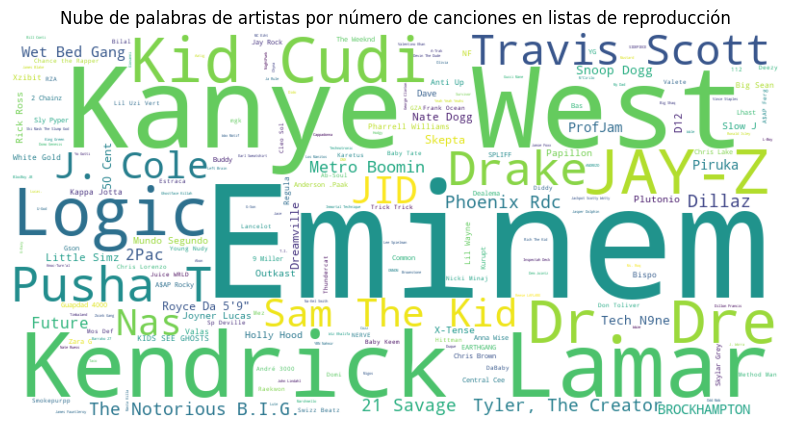

In [52]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(artist_song_count)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de artistas por número de canciones en listas de reproducción')
plt.show()